# Project 3: Sentiment analysis in movie reviews

In this project we are going to work with a dataset of movie reviews. The goal is to classify each review according to the positive or negative sentiment towards the movie. To do so, we will work with text processing and then apply predictive techniques.

## Importing libreries

In [ ]:
import pandas as pd
import warnings
warnings.filterwarnings("ignore")
pd.set_option('display.max_rows', 20000)
pd.set_option('display.max_columns', 20000)
import sklearn
from sklearn.datasets import load_files
from sklearn.model_selection import train_test_split
import re
# imports the natural language toolkit
import nltk
from nltk.stem import WordNetLemmatizer
from nltk.corpus import stopwords 
nltk.download('stopwords')
# Setting English stopwords
stops = set(stopwords.words('english'))
from nltk.tokenize import word_tokenize 
nltk.download('punkt')
nltk.download('wordnet')
nltk.download('omw-1.4')
from wordcloud import WordCloud,STOPWORDS
from sklearn.feature_extraction.text import TfidfVectorizer, CountVectorizer
from sklearn.model_selection import GridSearchCV
from sklearn.svm import LinearSVC
from sklearn.linear_model import LogisticRegression, SGDClassifier
import numpy as np
import itertools
from nltk.util import ngrams
from collections import Counter
import matplotlib.pylab as plt
import seaborn as sns
from sklearn.neighbors import KNeighborsClassifier
from sklearn.metrics import confusion_matrix, roc_auc_score, classification_report, accuracy_score, roc_curve, auc, confusion_matrix
from sklearn.ensemble import RandomForestClassifier, AdaBoostClassifier, VotingClassifier
from sklearn.naive_bayes import MultinomialNB
from sklearn.neural_network import MLPClassifier
from tensorflow.keras import Sequential
from tensorflow.keras.layers import Dense, Activation
from tensorflow.keras.optimizers import SGD
from xgboost import XGBClassifier
from lightgbm import LGBMClassifier
import joblib
import multiprocessing
# python implementation of world2vec
from gensim.models import Word2Vec
from gensim.models.phrases import Phrases, Phraser
from keras.wrappers.scikit_learn import KerasClassifier
from sklearn.decomposition import PCA
from sklearn.manifold import TSNE

## Loading dataset

In [2]:
moviedir = r'data/movie_reviews' 
# Loading all files
movie_reviews = load_files(moviedir, shuffle=True, encoding = 'utf-8')

## Exploring data

In [3]:
print("There are {} reviews, with the classes {}".format(len(movie_reviews.data), movie_reviews.target_names))

There are 2000 reviews, with the classes ['neg', 'pos']


In [4]:
# First file
movie_reviews.data[0][:1000]

"arnold schwarzenegger has been an icon for action enthusiasts , since the late 80's , but lately his films have been very sloppy and the one-liners are getting worse . \nit's hard seeing arnold as mr . freeze in batman and robin , especially when he says tons of ice jokes , but hey he got 15 million , what's it matter to him ? \nonce again arnold has signed to do another expensive blockbuster , that can't compare with the likes of the terminator series , true lies and even eraser . \nin this so called dark thriller , the devil ( gabriel byrne ) has come upon earth , to impregnate a woman ( robin tunney ) which happens every 1000 years , and basically destroy the world , but apparently god has chosen one man , and that one man is jericho cane ( arnold himself ) . \nwith the help of a trusty sidekick ( kevin pollack ) , they will stop at nothing to let the devil take over the world ! \nparts of this are actually so absurd , that they would fit right in with dogma . \nyes , the film is t

In [5]:
# First file is a negative review
movie_reviews.target[0]

0

In [6]:
# Sentiment count
(unique, counts) = np.unique(movie_reviews.target, return_counts=True)
np.asarray((unique, counts)).T

array([[   0, 1000],
       [   1, 1000]])

We can see that the dataset is balanced.

## Splitting into training and testing sets

Let’s split our data into train and test data using the `train_test_split` of Scikit-learn.

In [7]:
X_train, X_test, y_train, y_test = train_test_split(movie_reviews.data,
                                                    movie_reviews.target,
                                                    test_size = 0.2,
                                                    stratify = movie_reviews.target,
                                                    random_state = 12)

In [8]:
# Shape
print(len(X_train))
print(len(X_test))

1600
400


In [9]:
train = pd.DataFrame({'review': X_train})
train['sentiment'] = y_train
test = pd.DataFrame({'review': X_test})
test['sentiment'] = y_test

In [10]:
train.sample()

,review,sentiment
76,"to paraphrase a song title from an earlier disney movie , mulan is a whole new world . \nthe mouse factory's latest feature is a treasure , featuring magnificent animation , a strong story and finely drawn characters . \nmulan is the story of a fiesty , head-strong young woman who , unlike other disney heroines , isn't seeking her prince charming , \nmulan's motivations are simple ; to save her father , serve her country and find a place for herself in a world in which females have no say . \nthe story of mulan takes place in ancient china at a time when the huns have invaded the nation . \nthe emperor has called for a conscription , one man from each family to join the army and defend the nation . \nmulan's crippled father is called , but mulan sneaks off , steals his armor and takes his place . \nmulan is a saga of courage and self-discovery . \nyet , despite the grim backdrop of war , it is a lively tale of self-reliance and brain-over-brawn that even the smallest child can appreciate and enjoy . \nthe movie utilizes a strong corps of asian-american talent as the voices for the main characters , including the wonderful ming-na wen ( the joy luck club ) as mulan , b . d . \nwong as shang , mulan's commanding officer and later love interest , pat morita as the emperor and the veteran soon-tek oh as mulan's proud , but loving father . \nalso adding to the proceedings is eddie murphy as mushu the dragon , sent by mulan's ancestors to watch over and help the young woman . \nhis fast , wise-cracking , hip-talking mushu may seem out of place , but it's a crowd pleasing performance , especially for the youngsters . \nthe movie features only a couple of songs , fewer than most previous disney animated flicks , but mulan's are winners . \nthe music by matthew wilder and lyrics by david zippel fit nicely into the plot . \nthe overall score by jerry goldsmith also is a plus . \nmulan is a treat , more powerful than hercules , with more heart than the hunchback of notre dame . \nat about 85 minutes , mulan moves rapidly , and will hold the attention of youngsters from beginning to the end . \nmulan will set a new standard by which future animated efforts by disney and other studios will have to work hard to attain . \nalso , it is hoped that the success of mulan , and there is no doubt that it will prove to be a popular vehicle , will spur an interest for more movies with oriential or asian-american themes so as to provide more substantial roles for the talented performers who gave their voices for this production . \nit would be nice to see them on screen as well as hear them . \ncommitted to lifelong learning through effective communication \n",1


## Visualizations

### Size of reviews

In [11]:
# shortest and longest reviews
review_words_lengths = train.review.apply(lambda x: len(nltk.word_tokenize(x)))
print(min(review_words_lengths))
print(max(review_words_lengths))

18
2753


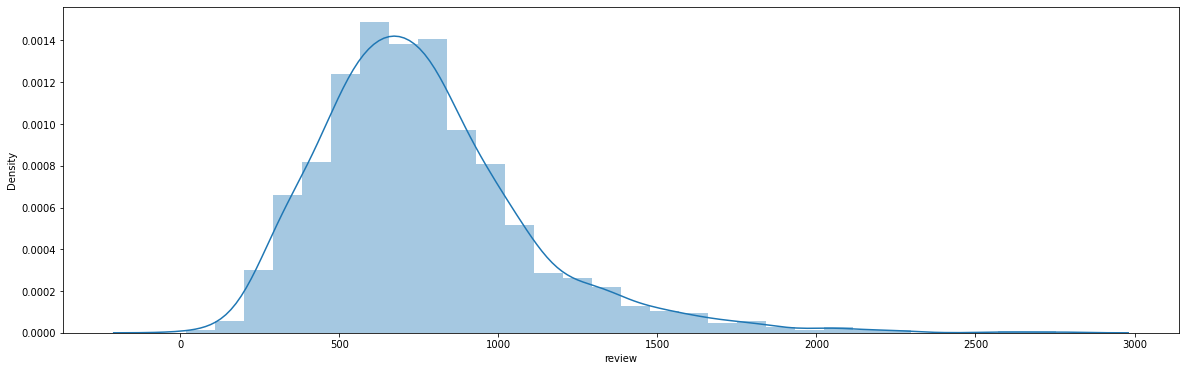

In [12]:
plt.figure(figsize = (20,6))
sns.distplot(review_words_lengths, bins=30);

### Text visualization with word clouds

In [13]:
def word_cloud(data, sentiment):
    
    data_filtered = data[data.sentiment == sentiment] 
    reviews = data_filtered.review
    reviews_text = ' '.join(reviews.values) 

    # Creating a word cloud object
    wordcloud = WordCloud(max_font_size=100, max_words=100, background_color="white",\
                          scale = 10, width=800, height=400).generate(reviews_text)

    # Plotting the generated word cloud
    plt.figure(figsize = (30, 60))
    plt.imshow(wordcloud, interpolation="bilinear")
    plt.axis("off")
    plt.show()

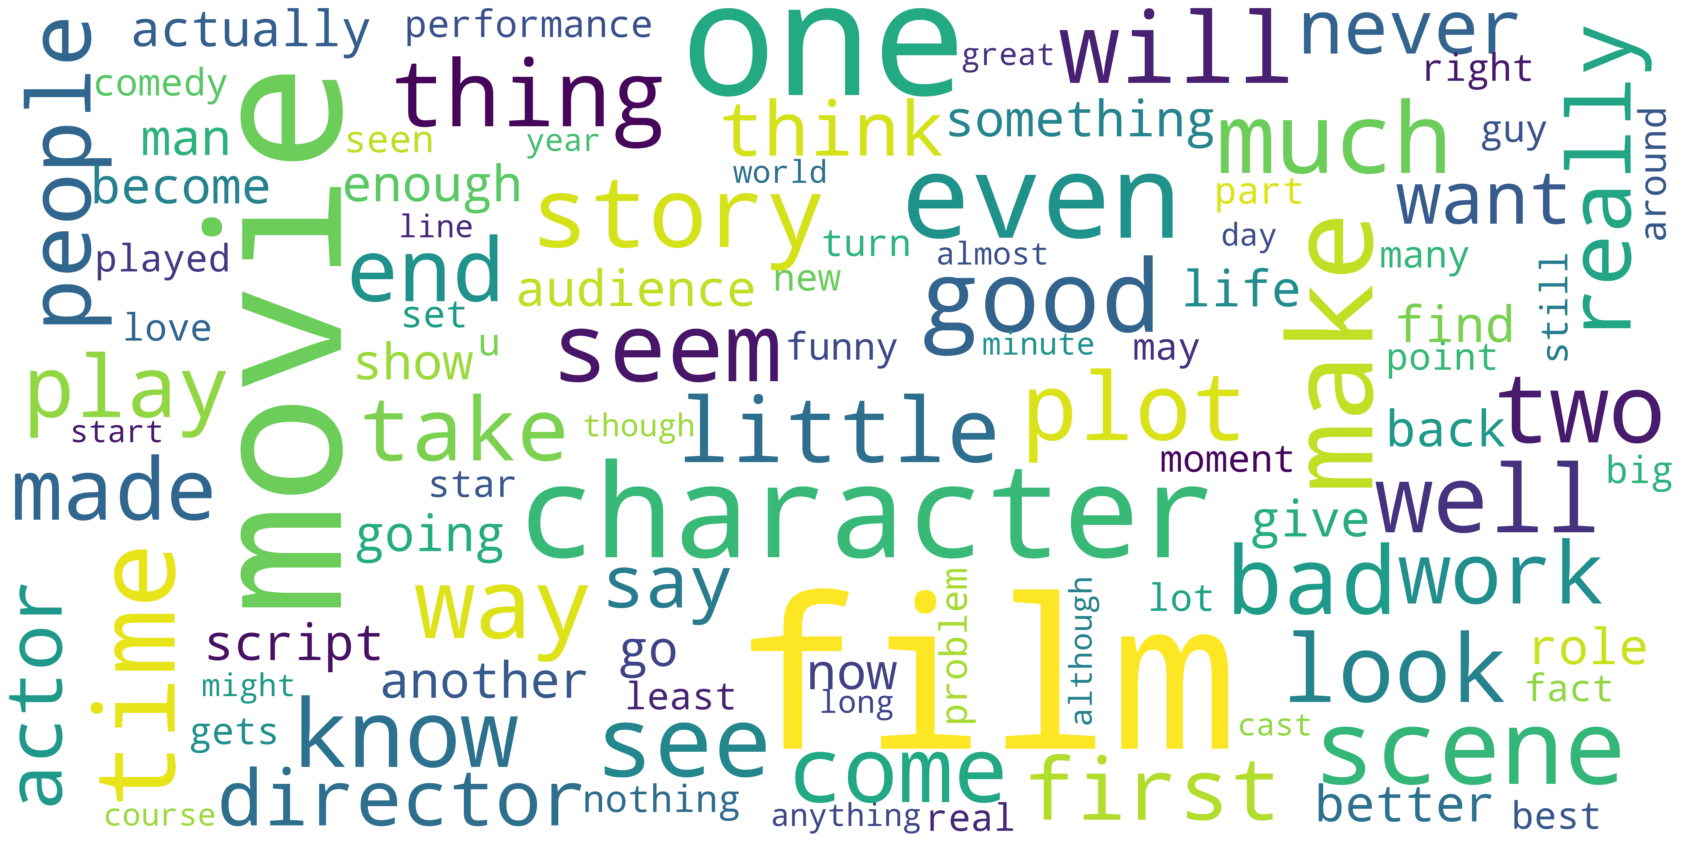

In [14]:
# Word cloud for nehative reviews
word_cloud(train, 0)

The word "good" seems to appear quite frequently in the negative reviews. Let's investigate why that is.

In [15]:
# Let's look at the first 5 reviews or so with negative reviews to see if there are any discernible patterns:
reviews_containing_good = [each for each in train[train.sentiment == 0].review if 'good' in each]

for review in reviews_containing_good[:20]:
    good_index = review.find("good")
    print(review[good_index-30:good_index+30].replace("\n", ""))

( let's face it ; exactly how good can a live-action disney 
 bad , but nothing resembling good either . her poison ivy 
e impossible to really have a good time . playing god asks 
es has come to video games . good truck driver jack crews (
prises . so again , the only good thing about it is its tec

 ! ) which is actually quite good . existenz is too predic
ening credits . ) so what is good about the movie ? well a
t do him service . tucker is good in the movie -- and this 
y the price . there are many good , respectable performance
ange of performances , either good or bad . for 8mm , he de
 , there's a couple of pretty good jabs at the spice girls .
heresas , as benevolent as do-gooders come . if they're to 
 programming director for the good buy home shopping network
 next fall " , as we find the good doctor quietly observing 
er is no . but it's not very good either . the major probl
 six better if you count john goodman ) , since here we have
ge seemed , in comparison , a good on

Reading each of the reviews, it is clear that "good" is often mentioned in a context like "only good" or "good doctor". This indicates that in the world of text we cannot go by single words (also called 1-grams) alone. The context of the sentence or the surrounding words at least are very much necessary to understand the sentiment of a sentence.

### High-frecuency and low-frequency words

Let's find high-frequency and low-frequency words in the reviews overall.

In [16]:
all_reviews_text = ' '.join(train.review)
tokenized_words = nltk.word_tokenize(all_reviews_text)
word_freq = Counter(tokenized_words)
print(len(word_freq))

41989


In [17]:
# Most common words
print(word_freq.most_common(50))

[(',', 62059), ('the', 60787), ('.', 52844), ('a', 30432), ('and', 28235), ('of', 27063), ('to', 25475), ('is', 20839), ('in', 17171), ("'s", 14399), ('``', 13772), ('it', 12794), ('that', 12689), (')', 9439), ('(', 9348), ('as', 9029), ('with', 8606), ('for', 7970), ('this', 7662), ('his', 7582), ('film', 7529), ('i', 7105), ('he', 7048), ('but', 6804), ('on', 5805), ('are', 5766), ("n't", 5002), ('by', 4904), ('be', 4901), ('an', 4658), ('movie', 4631), ('not', 4533), ('who', 4513), ('one', 4458), ('you', 4305), ('was', 4095), ('have', 4027), ('from', 3991), ('at', 3959), ('they', 3880), ('has', 3842), ('her', 3627), ('all', 3385), ('there', 3039), ('?', 2951), ('so', 2916), ('like', 2825), ('about', 2797), ('out', 2761), ('what', 2675)]


In [18]:
print(word_freq.most_common()[-50:-1])

[('richman', 1), ('solidifying', 1), ('faux-sympathy', 1), ('buttercup', 1), ('branched', 1), ('co-owns', 1), ('uptown', 1), ('eatery', 1), ('anchor/correspondant', 1), ('ick', 1), ('ever-versatile', 1), ('uhhhm', 1), ('ball-picking', 1), ('rigs', 1), ('sluttier', 1), ('roughneck', 1), ('ne', 1), ('sais', 1), ('quoi', 1), ('scrapped', 1), ('highly-anticipated', 1), ('slotted', 1), ('demotion', 1), ('much-loathed', 1), ('catsuit-clad', 1), ('imbuing', 1), ('sassiness', 1), ('crippling', 1), ('volley', 1), ('fizzling', 1), ('usually-splendid', 1), ('inroad', 1), ('commendably', 1), ('regrettably-neglected', 1), ('kathyrn', 1), ('cheekily', 1), ('caper-esque', 1), ('restlessly', 1), ('veritably', 1), ('twiggish', 1), ('ever-bemused', 1), ('tandem', 1), ('combating', 1), ('climate-controlling', 1), ('crisply', 1), ('bees', 1), ('slugging', 1), ('quickest', 1), ('outings', 1)]


### Top n-grams

In [19]:
def top_k_ngrams(word_tokens, n, k):
    
    # Printing the top  𝑘  n-grams
    n_gram_list = list(ngrams(word_tokens, n))
    n_gram_strings = [' '.join(each) for each in n_gram_list]
    n_gram_counter = Counter(n_gram_strings)
    most_common_k = n_gram_counter.most_common(k)
    
    return most_common_k

In [20]:
all_reviews_text = ' '.join(train.review)
word_tokens = nltk.word_tokenize(all_reviews_text)
top_k_ngrams(word_tokens, 3, 10)

[('. . .', 1308),
 (". it 's", 980),
 ('one of the', 801),
 (', and the', 736),
 ('of the film', 700),
 (", it 's", 580),
 ('. the film', 520),
 ('in the film', 468),
 (', but it', 449),
 ('. this is', 449)]

Very common words are usually uninformative, and their very large occurrence values can distort the results of many NLP algorithms. For this reason, it is common to pre-process text by removing words that you have a reason to believe are uninformative; these words are called [**stop words**](https://en.wikipedia.org/wiki/Stop_words). 

In [21]:
print(stopwords.words("english"))

['i', 'me', 'my', 'myself', 'we', 'our', 'ours', 'ourselves', 'you', "you're", "you've", "you'll", "you'd", 'your', 'yours', 'yourself', 'yourselves', 'he', 'him', 'his', 'himself', 'she', "she's", 'her', 'hers', 'herself', 'it', "it's", 'its', 'itself', 'they', 'them', 'their', 'theirs', 'themselves', 'what', 'which', 'who', 'whom', 'this', 'that', "that'll", 'these', 'those', 'am', 'is', 'are', 'was', 'were', 'be', 'been', 'being', 'have', 'has', 'had', 'having', 'do', 'does', 'did', 'doing', 'a', 'an', 'the', 'and', 'but', 'if', 'or', 'because', 'as', 'until', 'while', 'of', 'at', 'by', 'for', 'with', 'about', 'against', 'between', 'into', 'through', 'during', 'before', 'after', 'above', 'below', 'to', 'from', 'up', 'down', 'in', 'out', 'on', 'off', 'over', 'under', 'again', 'further', 'then', 'once', 'here', 'there', 'when', 'where', 'why', 'how', 'all', 'any', 'both', 'each', 'few', 'more', 'most', 'other', 'some', 'such', 'no', 'nor', 'not', 'only', 'own', 'same', 'so', 'than', '

In [22]:
# Removing the most basic stop words from the ntlk corpus and including only those
# words with character size above 2 so as to remove punctuations
# But, this could be extended to remove further high and low frequency stop words

word_tokens = nltk.word_tokenize(all_reviews_text)
word_tokens_clean = [each for each in word_tokens if each.lower() not in STOPWORDS and len(each.lower()) > 2]
top_k_ngrams(word_tokens_clean, 3, 20)

[('know last summer', 52),
 ('new york city', 40),
 ('good will hunting', 40),
 ('tommy lee jones', 39),
 ('wild wild west', 30),
 ('saving private ryan', 29),
 ('jay silent bob', 27),
 ('film takes place', 24),
 ("movie 've seen", 22),
 ('saturday night live', 22),
 ('little known facts', 21),
 ('blair witch project', 21),
 ("'ve got mail", 20),
 ('babe pig city', 20),
 ("'ve never seen", 19),
 ('house haunted hill', 18),
 ('thin red line', 17),
 ("film 've seen", 15),
 ('jean-claude van damme', 15),
 ('star trek insurrection', 15)]

## Data Preprocessing

### Cleaning & normalization

* Remove stopwords
* Remove characters
* Tokenize text
* Lemmatizer

In [23]:
def normalizer(review):   
    
    # Remove characters like numeric characters, punctuations etc.
    only_letters = re.sub("[^a-zA-Z]", " ", review)
    # Tokenization of text: splitting a long document into its component sentences
    word_tokens = nltk.word_tokenize(only_letters)  
    # Remove the stopwords and get the stem words only
    filtered_result = list(filter(lambda x: x not in stops, word_tokens)) 
    # Return the base or dictionary form of a word, which is known as the lemma
    wordnet_lemmatizer = WordNetLemmatizer()
    lemma = [wordnet_lemmatizer.lemmatize(t) for t in filtered_result] 
    
    return " ".join(lemma)

In [24]:
train['normalized_review'] = train.review.apply(normalizer)
test['normalized_review'] = test.review.apply(normalizer)

In [25]:
train.sample()

,review,sentiment,normalized_review
212,"a suave , cool , collected , rich , uptight bad guy = cliche . \na clumsy criminal oaf to add to the laughs = cliche . \na bad guy who owns a wild animal = cliche . \na crooked , chauvinistic law enforcer type = cliche . \nat an intense moment , our main character tries to get away , but the car has trouble starting = cliche . \ncomplaining about cliches = cliche . \nok , ok . \nso we always hear about cliches . \nbut if there was ever to be a prime example , the real mccoy is it ! \nnot one uttered word , not one frame of film , not one character in this whole movie isn't a cut and paste example of everything we've ever seen . \nthey might as well use this as a training film : "" how to make a bank robbery film in the 90's "" . \nkaren mccoy ( kim basinger ) is a bank robber who just got out on parole after a six-year stay at the state prison . \nshe wants to make things right and go straight , especially with the fact that she has a six-year old son out there who doesn't even know she's alive . \naware of mccoy's bank robbing expertise , sniveling bad guy jack schmidt ( terence stamp ) uses the same six-year old to coerce mccoy into returning to her past . \nhe wants mccoy to pull off an elaborate heist of 18+ million dollars at the same bank she got caught trying to rob six years earlier , which , by the way , is somehow due to schmidt . \nand if she refuses ? \nwho knows what he'll do to the kid . \n ( cue sinister laughter ) \nthis movie is so pathetically pitiful that it's hard to know where to begin . \nthe aforementioned cliches are brutally abundant . \ni can't stress enough how every single element , whether it be a character , the dialogue , a plot "" twist "" , etc . , is so damn generic that you'll wonder if * anyone * is working behind the scenes , let alone in front of the camera . \nbasinger is absolutely vacant . \nand where do they get off trying to make us emotionally attached to her ? \nhere's someone that spent their time robbing banks , and now as she heads onto the street , we're supposed to feel sorry for her . \nas she confronts her son , who doesn't even know who she is , are we supposed to break into tears ? ? \nespecially when neither basinger nor zach english , who plays the kid , has any depth or emotional-radiance whatsoever . \ni suppose i should mention val kilmer . \nyeah , that's right - he's in it ! \nquite sadly too , seeing as how i can discuss everything about the movie and never mention his name . \nand he got second billing ! \nto be fair , i will admit that kilmer had potential in his role as the bumbling criminal wannabe j . t . \nbarker . \nunfortunately the script doesn't allow much room for improvement , and when his character is used like bookends ( he never shows up in the middle of the film ! ) , \nwe have no time to appreciate what he might have brought to this project . \nthe real mccoy just can't keep it's head above water , and soon , * very * soon , sinks into a cliched mess of movie . \nthe actors are like dummies being moved about by an unenthusiastic puppeteer , and the dialogue , particularly schmidt's trite dialogue , falls like the niagra . \nthis is definitely one to avoid , folks . \nthe real mccoy is anything but ! \n",0,suave cool collected rich uptight bad guy cliche clumsy criminal oaf add laugh cliche bad guy owns wild animal cliche crooked chauvinistic law enforcer type cliche intense moment main character try get away car trouble starting cliche complaining cliche cliche ok ok always hear cliche ever prime example real mccoy one uttered word one frame film one character whole movie cut paste example everything ever seen might well use training film make bank robbery film karen mccoy kim basinger bank robber got parole six year stay state prison want make thing right go straight especially fact six year old son even know alive aware mccoy bank robbing expertise sniveling bad guy jack schmidt terence stamp us six year ol

### Finding important words

In [26]:
# Following code grabbed from:
# https://towardsdatascience.com/a-complete-exploratory-data-analysis-and-visualization-for-text-data-29fb1b96fb6a
# we will use it in our context to create some visualizations.
def get_top_n_words(corpus, n=1, k=1):
    
    vec = CountVectorizer(ngram_range=(k,k)).fit(corpus)
    bag_of_words = vec.transform(corpus)
    sum_words = bag_of_words.sum(axis=0) 
    words_freq = [(word, sum_words[0, idx]) for word, idx in vec.vocabulary_.items()]
    words_freq =sorted(words_freq, key = lambda x: x[1], reverse=True)
    
    return words_freq[:n]

In [27]:
# We continue by splitting according to good/bad review scores, then grabbing again.

GoodRev = train[train.sentiment == 1]
BadRev = train[train.sentiment == 0]

common_words_good_rev = get_top_n_words(GoodRev['normalized_review'], 20)
common_words_bad_rev = get_top_n_words(BadRev['normalized_review'], 20)

good_rev_df = pd.DataFrame(common_words_good_rev, columns = ['word' , 'count']).sort_values(by=['count'], ascending=False)
bad_rev_df = pd.DataFrame(common_words_bad_rev, columns = ['word' , 'count']).sort_values(by=['count'], ascending=False)

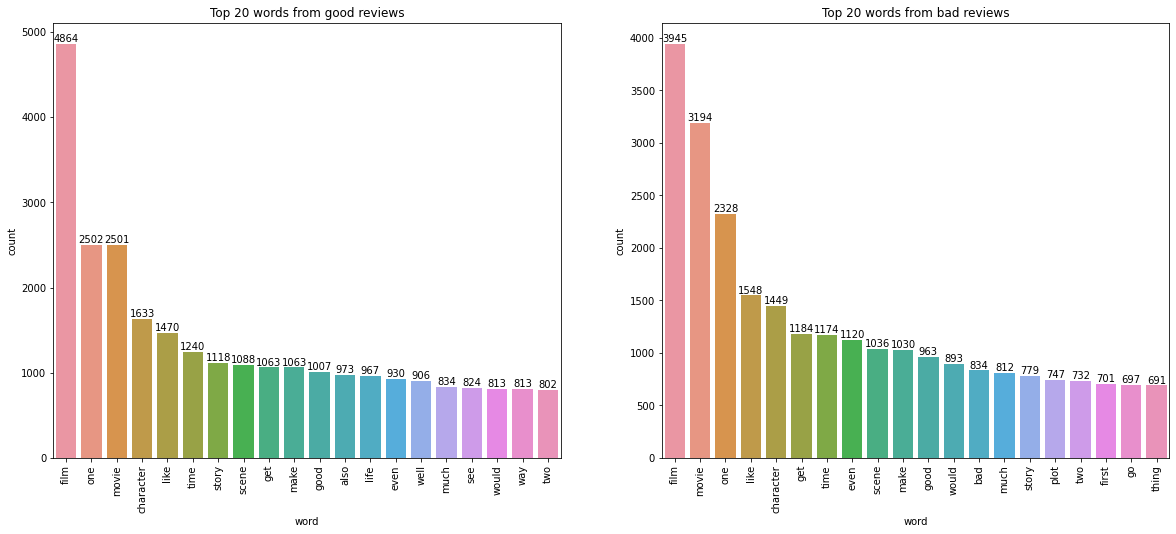

In [28]:
f, ax = plt.subplots(1,2,figsize=(20, 8))
ax[0] = sns.barplot(x='word', y='count', data=good_rev_df, ax=ax[0])
ax[0].set_title('Top 20 words from good reviews')
ax[0].tick_params(axis='x', labelrotation=90)
for container in ax[0].containers:
    ax[0].bar_label(container)
ax[1] = sns.barplot(x='word', y='count', data=bad_rev_df, ax=ax[1])
ax[1].set_title('Top 20 words from bad reviews')
ax[1].tick_params(axis='x', labelrotation=90)
for container in ax[1].containers:
    ax[1].bar_label(container);

In [29]:
# top 20 bigrams and trigrams

common_bigrams_good_rev = get_top_n_words(GoodRev['normalized_review'], 20, 2)
common_bigrams_bad_rev = get_top_n_words(BadRev['normalized_review'], 20, 2)
common_trigrams_good_rev = get_top_n_words(GoodRev['normalized_review'], 20, 3)
common_trigrams_bad_rev = get_top_n_words(BadRev['normalized_review'], 20, 3)

common_bigrams_good_rev_df = pd.DataFrame(common_bigrams_good_rev, columns = ['word', 'count']).sort_values(by=['count'], ascending=False)
common_bigrams_bad_rev_df = pd.DataFrame(common_bigrams_bad_rev, columns = ['word', 'count']).sort_values(by=['count'], ascending=False)
common_trigrams_good_rev_df = pd.DataFrame(common_trigrams_good_rev, columns = ['word', 'count']).sort_values(by=['count'], ascending=False)
common_trigrams_bad_rev_df = pd.DataFrame(common_trigrams_bad_rev, columns = ['word', 'count']).sort_values(by=['count'], ascending=False)

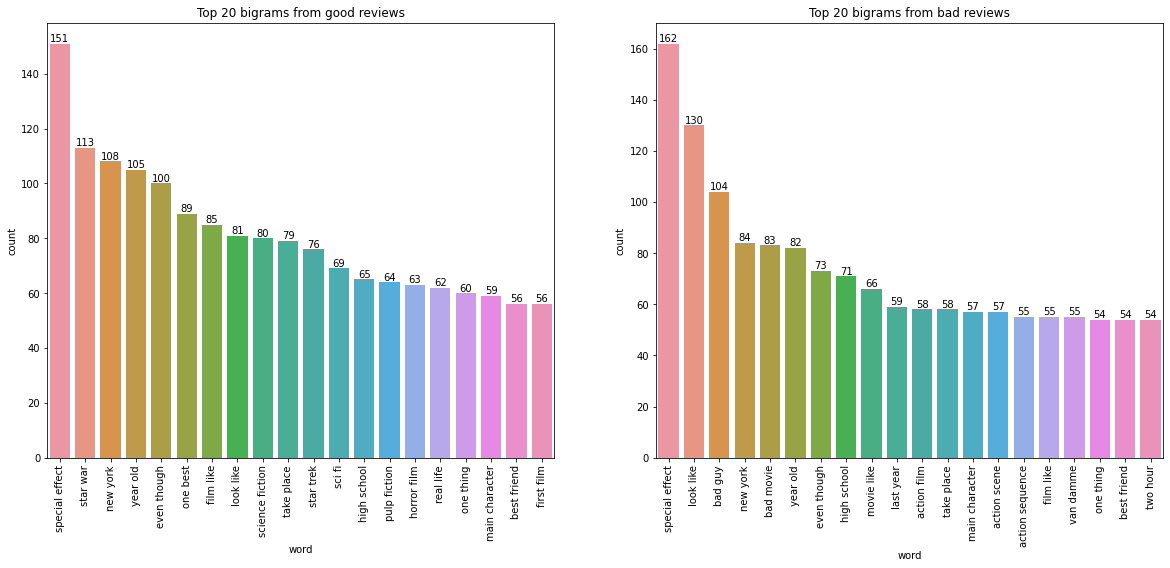

In [30]:
f, ax = plt.subplots(1,2,figsize=(20, 8))
ax[0] = sns.barplot(x='word', y='count', data=common_bigrams_good_rev_df, ax=ax[0])
ax[0].set_title('Top 20 bigrams from good reviews')
ax[0].tick_params(axis='x', labelrotation=90)
for container in ax[0].containers:
    ax[0].bar_label(container)
ax[1] = sns.barplot(x='word', y='count', data=common_bigrams_bad_rev_df, ax=ax[1])
ax[1].set_title('Top 20 bigrams from bad reviews')
ax[1].tick_params(axis='x', labelrotation=90)
for container in ax[1].containers:
    ax[1].bar_label(container);

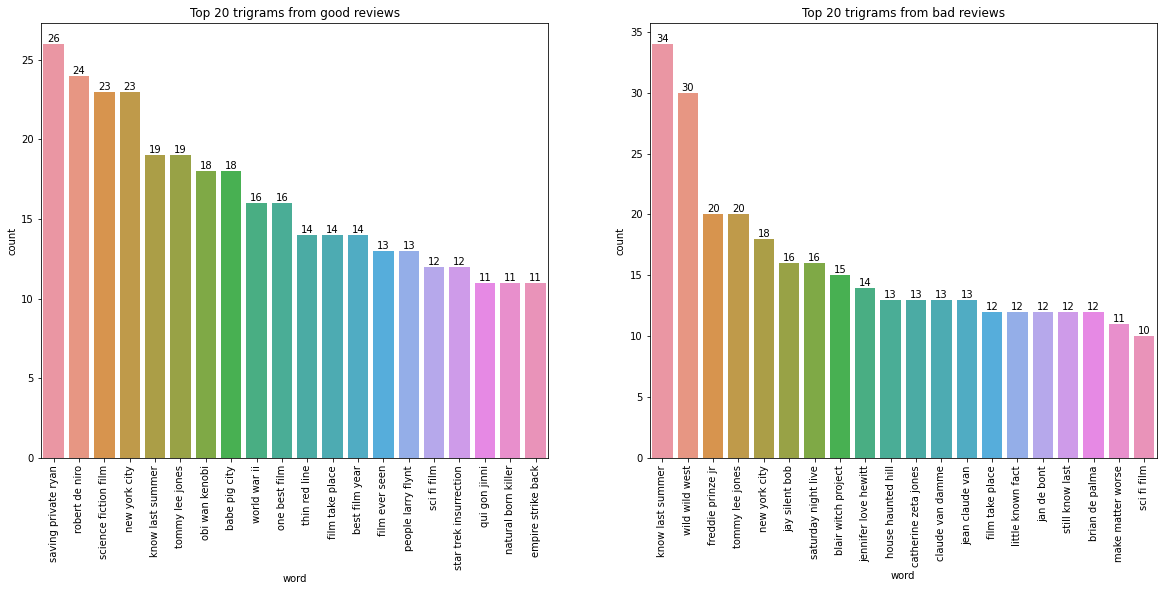

In [31]:
f, ax = plt.subplots(1,2,figsize=(20, 8))
ax[0] = sns.barplot(x='word', y='count', data=common_trigrams_good_rev_df, ax=ax[0])
ax[0].set_title('Top 20 trigrams from good reviews')
ax[0].tick_params(axis='x', labelrotation=90)
for container in ax[0].containers:
    ax[0].bar_label(container)
ax[1] = sns.barplot(x='word', y='count', data=common_trigrams_bad_rev_df, ax=ax[1])
ax[1].set_title('Top 20 trigrams from bad reviews')
ax[1].tick_params(axis='x', labelrotation=90)
for container in ax[1].containers:
    ax[1].bar_label(container);

### Extracting adjectives

It is interesting to look specifically at Adjectives (which have a tag name of "JJ" in NLTK) when looking at reviews. We can hypothesise that good reviews and bad reviews might use very different adjectives, but that some adjectives might appear often in both good and bad reviews, as we saw with the word "good" previously.

In [32]:
def extract_specific_pos(reviews, pos_tag):
    results = [] 
    for review in reviews:
        words = nltk.word_tokenize(review)
        tagged = nltk.pos_tag(words)
        keep = [x[0] for x in tagged if x[1] == pos_tag]
        results += keep
    return results


negative_adjectives = extract_specific_pos(GoodRev['normalized_review'], "JJ")
positive_adjectives = extract_specific_pos(BadRev['normalized_review'], "JJ")

print(Counter(negative_adjectives).most_common(30))
print('')
print(Counter(positive_adjectives).most_common(30))

[('good', 996), ('much', 626), ('many', 621), ('great', 592), ('little', 588), ('new', 576), ('u', 466), ('first', 395), ('real', 391), ('old', 382), ('big', 361), ('young', 349), ('last', 336), ('american', 335), ('bad', 286), ('original', 274), ('funny', 270), ('high', 266), ('black', 248), ('special', 235), ('right', 235), ('human', 234), ('true', 229), ('small', 210), ('different', 207), ('several', 202), ('hard', 194), ('alien', 194), ('final', 190), ('sure', 186)]

[('good', 938), ('bad', 834), ('much', 611), ('little', 569), ('big', 472), ('new', 442), ('many', 400), ('u', 399), ('first', 369), ('real', 363), ('last', 355), ('funny', 335), ('old', 323), ('great', 311), ('original', 277), ('young', 249), ('whole', 224), ('high', 224), ('special', 207), ('hard', 199), ('enough', 189), ('second', 188), ('sure', 186), ('black', 184), ('dead', 174), ('wrong', 168), ('main', 167), ('human', 166), ('stupid', 164), ('right', 161)]


### Validation corpus

The validation corpus is going to be a piece of our training corpus that we are going to use iteration by iteration to see if our model improves or not and thus know when we are going to stop iterating. This technique is called early stopping.

Several models (such as the keras Neural Network model we are going to use) already have this functionality incorporated and directly take the validation corpus as a parameter together with a maximum number of iterations. The model will therefore continue to iterate as long as the evaluation on the validation corpus is better than in the previous iteration or until the maximum number of iterations is reached.


We will divide the train corpus into a minor train corpus and a validation corpus (20% of the train corpus).

In [33]:
training, validation = train_test_split(train, test_size=0.2, random_state=42)

print(training.shape)
print(validation.shape)
print(test.shape)

(1280, 3)
(320, 3)
(400, 3)


In [34]:
y_train = training.sentiment

### Vectorization

To enable Scikit-learn algorithms to work on our text, we need to convert each review into a vector.

#### Bags of words

[Count Vectorizer](https://scikit-learn.org/stable/modules/generated/sklearn.feature_extraction.text.CountVectorizer.html)

* `max_df`: When building the vocabulary ignore terms that have a document frequency strictly higher than the given threshold.
* `min_df`: When building the vocabulary ignore terms that have a document frequency strictly lower than the given threshold.

If `min_df` is $0.005$, all words that represent less than $0.5%$ of the total words will be discarded. On the other hand, if `max_df` is $0.35$, all words that represent more than $35%$ of the total words will be discarded. 

We are interested in discarding words with too much frequency because they probably have no value in terms of the entropy they contribute (i.e., they do not provide information: they may be connectors, articles, etc.) and those with too little frequency because they may be outliers, words that are too specific and do not contribute to the task we want to develop.

* `ngram_range`: The lower and upper boundary of the range of n-values for different word n-grams or char n-grams to be extracted. 

<img src="img/n-gram.png" alt="ngrams" width="500"/>

In [35]:
text_train = training.normalized_review
text_validation = validation.normalized_review
text_test = test.normalized_review

vectorizer = CountVectorizer(binary=True, min_df = 0.004, max_df = 0.7, ngram_range=(1, 3))
bag_of_words = vectorizer.fit_transform([*text_train, *text_validation, *text_test])

BOW_train = bag_of_words[:len(text_train)]
BOW_validation = bag_of_words[len(text_train):-len(text_test)]
BOW_test = bag_of_words[-len(text_test):]   

print('BOW_train:', BOW_train.shape)
print('BOW_validation:', BOW_validation.shape)
print('BOW_test:', BOW_test.shape)

BOW_train: (1280, 13359)
BOW_validation: (320, 13359)
BOW_test: (400, 13359)


#### Term Frequency Inverse Document Frequency

<img src="img/tf-idf.png" alt="tf-idf" width="500"/>

#### Word2Vec

The underlying assumption of Word2Vec is that two words that share similar contexts also share a similar meaning and, consequently, a similar vector representation of the model. 

In [36]:
input = [row.split() for row in train.normalized_review]
phrases = Phrases(input, min_count=30, progress_per=1000) 
bigram = Phraser(phrases)
sentences = bigram[input] 

In [37]:
# Count the number of cores in a computer
cores = multiprocessing.cpu_count()

w2v_model = Word2Vec(min_count=20, # ignora palabras cuya frecuencia es menor a esta
                     window=2, # tamanio de la ventana de contexto
                     sample=6e-5, # umbral para downsamplear palabras muy frecuentes
                     alpha=0.03, # tasa de aprendizaje inicial (entrenamiento de la red neuronal)
                     min_alpha=0.0007, # tasa de aprendizaje minima
                     negative=20, # penalidad de palabras muy frecuentes o poco informaitvas
                     workers=cores) # numero de cores para entrenar el modelo

In [38]:
w2v_model.build_vocab(sentences, progress_per=10000) # construye el vocabulario
w2v_model.train(sentences, total_examples=w2v_model.corpus_count, epochs=30, report_delay=1) # entrena el modelo
w2v_model.init_sims(replace=True) # precomputa distancias

In [39]:
w2v_model.wv.most_similar(positive=["good"])

[('reasonably', 0.6449588537216187),
 ('really', 0.6333185434341431),
 ('fun_watch', 0.628017783164978),
 ('bad', 0.6184876561164856),
 ('chuckle', 0.6182379722595215),
 ('funnier', 0.5990524291992188),
 ('fun', 0.5961408615112305),
 ('pretty', 0.5911567807197571),
 ('rest_cast', 0.5866568684577942),
 ('honestly', 0.5810657739639282)]

In [40]:
w2v_model.wv.most_similar(positive=["bad"])

[('terrible', 0.7100621461868286),
 ('awful', 0.6865906715393066),
 ('pretty', 0.6456999182701111),
 ('good', 0.6184877157211304),
 ('horrible', 0.6164813041687012),
 ('kinda', 0.605939507484436),
 ('fun_watch', 0.6044453382492065),
 ('mimic', 0.6041136384010315),
 ('said', 0.603764533996582),
 ('worse', 0.5970727205276489)]

In [41]:
w2v_model.wv.most_similar(positive=["man"])

[('brutally', 0.5511251091957092),
 ('prostitute', 0.546709418296814),
 ('gentleman', 0.544189453125),
 ('murdered', 0.537141740322113),
 ('profession', 0.5313555002212524),
 ('von', 0.5278208255767822),
 ('convict', 0.5215325355529785),
 ('rubber', 0.5208897590637207),
 ('chased', 0.5181077122688293),
 ('determined', 0.5163599252700806)]

In [42]:
w2v_model.wv.most_similar(positive=["woman"])

[('fall_love', 0.7274441123008728),
 ('rich', 0.6681428551673889),
 ('dora', 0.6597182750701904),
 ('unhappy', 0.6584546566009521),
 ('elderly', 0.6499149799346924),
 ('beautiful', 0.6463451981544495),
 ('flower', 0.6399905681610107),
 ('neighborhood', 0.6388589143753052),
 ('dancer', 0.6356158256530762),
 ('sexy', 0.6240492463111877)]

In [91]:
w2v_model.wv.most_similar(positive=["movie"])

[('goer', 0.7321995496749878),
 ('watchable', 0.706603467464447),
 ('glad', 0.6998759508132935),
 ('avenger', 0.6955312490463257),
 ('honestly', 0.6886252760887146),
 ('film', 0.6806675791740417),
 ('fun_watch', 0.6788361072540283),
 ('expecting', 0.676841139793396),
 ('walked', 0.6664178371429443),
 ('could', 0.6655628681182861)]

In [88]:
w2v_model.wv.most_similar(positive=["food"])

[('eat', 0.6790329813957214),
 ('eating', 0.6248539686203003),
 ('yell', 0.6094675064086914),
 ('factory', 0.6075332760810852),
 ('smoke', 0.6055912971496582),
 ('coffee', 0.5928075313568115),
 ('revealing', 0.5856994390487671),
 ('burst', 0.5834352374076843),
 ('customer', 0.5825206637382507),
 ('huh', 0.5779635906219482)]

In [89]:
w2v_model.wv.most_similar(positive=["world"])

[('virtual', 0.7419828176498413),
 ('reality', 0.6358882188796997),
 ('war', 0.6285015344619751),
 ('underground', 0.605637788772583),
 ('destroying', 0.6041426062583923),
 ('universe', 0.6021400094032288),
 ('triumph', 0.586450457572937),
 ('function', 0.5779606699943542),
 ('outside', 0.5751104354858398),
 ('jew', 0.5719776153564453)]

In [46]:
w2v_model.wv.most_similar(positive=["money"])

[('paid', 0.7118937969207764),
 ('ransom', 0.7064226865768433),
 ('ticket', 0.6959511041641235),
 ('pay', 0.6838599443435669),
 ('buy', 0.6489019393920898),
 ('paying', 0.632763147354126),
 ('demanding', 0.6301316618919373),
 ('debt', 0.6291317939758301),
 ('cash', 0.6262140274047852),
 ('price', 0.6217185854911804)]

In [47]:
#  “king is to queen as man is to woman“.
w2v_model.wv.most_similar(positive=["woman","king"], negative=["queen"], topn=10)

[('champion', 0.48620420694351196),
 ('men', 0.4821012616157532),
 ('bubble', 0.4534848630428314),
 ('comment', 0.44766101241111755),
 ('alcoholic', 0.446786105632782),
 ('fall_love', 0.43914595246315),
 ('assistant', 0.4336004853248596),
 ('ego', 0.432950496673584),
 ('truth', 0.42937085032463074),
 ('christine', 0.42825156450271606)]

##### t-SNE visualization

In [85]:
# List of vocabulary
vocab = list(w2v_model.wv.index_to_key)
print(vocab[:50])

['film', 'movie', 'one', 'character', 'like', 'get', 'time', 'make', 'scene', 'good', 'even', 'story', 'would', 'also', 'well', 'much', 'first', 'two', 'see', 'way', 'life', 'go', 'thing', 'really', 'little', 'people', 'plot', 'could', 'come', 'know', 'take', 'work', 'man', 'never', 'performance', 'many', 'end', 'actor', 'director', 'play', 'bad', 'best', 'year', 'u', 'find', 'role', 'made', 'action', 'back', 'great']


In [86]:
# index vector values by corresponding vocab list
X = w2v_model.wv[vocab]

print("Total Number of Vocab:", len(X))

# Visualize only 100 words.
tsne = TSNE(n_components = 2)
X_tsne = tsne.fit_transform(X[:100,:])

df = pd.DataFrame(X_tsne, index = vocab[:100], columns = ['X','Y'])
df.head()

Total Number of Vocab: 4525


,X,Y
film,4.350965,2.426445
movie,3.635382,1.952460
one,4.907774,0.221459
character,-2.848263,1.745056
like,0.125800,-1.307707


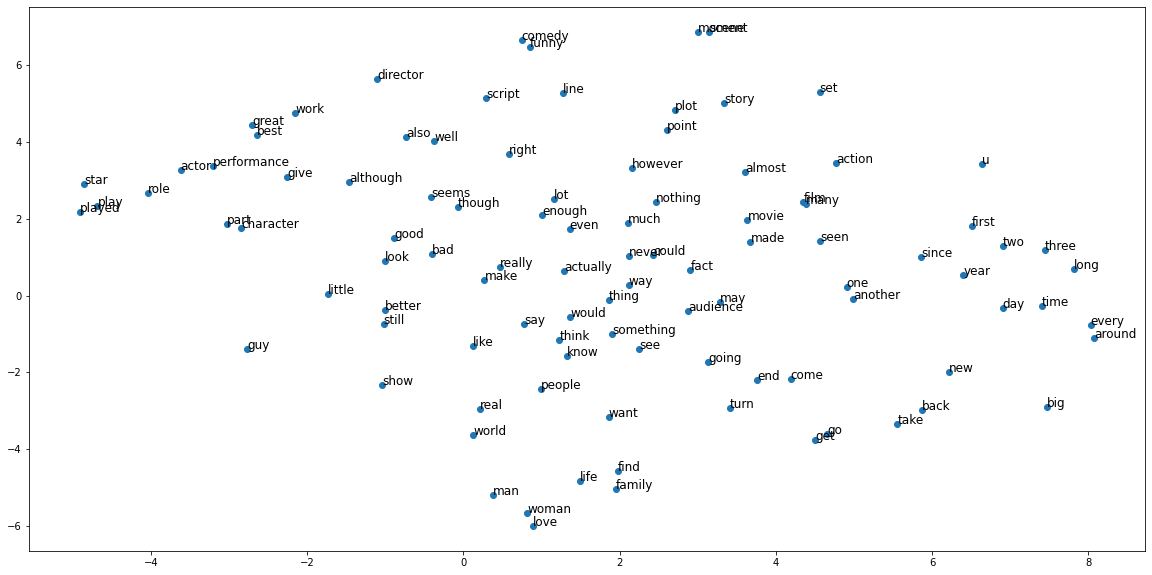

In [87]:
fig = plt.figure()
fig.set_size_inches(20, 10)

ax = fig.add_subplot(1,1,1)
ax.scatter(df['X'], df['Y'])

# Put the label on each point.
for word, pos in df.iterrows():
    ax.annotate(word, pos, fontsize = 12);

## Modeling


### Logistic Regression

-----Training-----
Accuracy: 1.00
ROC AUC: 1.00
-----Testing-----
Accuracy: 0.88
ROC AUC: 0.88

              precision    recall  f1-score   support

           0       0.88      0.88      0.88       200
           1       0.88      0.88      0.88       200

    accuracy                           0.88       400
   macro avg       0.88      0.88      0.88       400
weighted avg       0.88      0.88      0.88       400




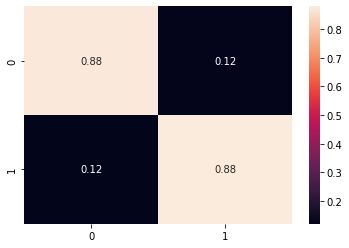

In [104]:
model = LogisticRegression(random_state=42)
model.fit(BOW_train, y_train)

print("-----Training-----")
y_pred_train =  model.predict(BOW_train)
accuracy_train = accuracy_score(y_train, y_pred_train)
print("Accuracy: %.2f" % accuracy_train)
print("ROC AUC: %.2f" % roc_auc_score(y_train, y_pred_train))

print("-----Testing-----")
y_pred_test =  model.predict(BOW_test)
accuracy_test = accuracy_score(y_test, y_pred_test)
print("Accuracy: %.2f" % accuracy_test)
print("ROC AUC: %.2f" % roc_auc_score(y_test, y_pred_test))

print('')
print(classification_report(y_test, y_pred_test), end="\n\n")
cm_test = confusion_matrix(y_test, y_pred_test, normalize='true')
sns.heatmap(cm_test, annot=True);

Best estimator: LogisticRegression(C=0.1)

ROC AUC: 0.88

Classification report:

              precision    recall  f1-score   support

    negative       0.89      0.87      0.88       200
    positive       0.87      0.90      0.88       200

    accuracy                           0.88       400
   macro avg       0.88      0.88      0.88       400
weighted avg       0.88      0.88      0.88       400




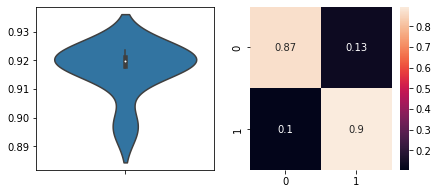

In [105]:
exploring_params = {
        "C": np.logspace(-3, 3, 7),
        "penalty": ["l1", "l2"]      
    }

model = LogisticRegression()
n_cross_val = 10 
scoring = "roc_auc"
grid_search = GridSearchCV(model, exploring_params, cv=n_cross_val, scoring=scoring)
grid_search.fit(BOW_train, y_train)
y_pred = grid_search.predict(BOW_test)
best_lr = grid_search.best_estimator_

print("Best estimator: {}".format(best_lr), end="\n\n")
print("ROC AUC: %.2f" % roc_auc_score(y_test, y_pred), end="\n\n")
print("Classification report:", end="\n\n")
print(classification_report(y_test, y_pred, target_names=['negative','positive']), end="\n\n")

means = grid_search.cv_results_['mean_test_score']
stds = grid_search.cv_results_['std_test_score']
cm_test = confusion_matrix(y_test, y_pred, normalize='true')

f, ax = plt.subplots(1, 2, figsize=(7, 3))
sns.violinplot(y=means, ax=ax[0])
sns.heatmap(cm_test, annot=True, ax=ax[1]);

### KNN

Best estimator: KNeighborsClassifier(metric='cosine', n_neighbors=8)

ROC AUC: 0.76

Classification report:

              precision    recall  f1-score   support

    negative       0.79      0.71      0.75       200
    positive       0.74      0.81      0.77       200

    accuracy                           0.76       400
   macro avg       0.76      0.76      0.76       400
weighted avg       0.76      0.76      0.76       400




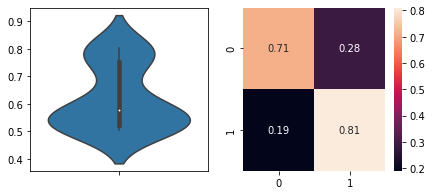

In [106]:
exploring_params = {
    'n_neighbors': range(1, 10),
    'metric': ['euclidean', 'cosine', 'manhattan']
    }

model = KNeighborsClassifier()
n_cross_val =  10 
scoring = "roc_auc"
grid_search = GridSearchCV(model, exploring_params, cv=n_cross_val, scoring=scoring)
grid_search.fit(BOW_train, y_train)
y_pred = grid_search.predict(BOW_test)
best_knn = grid_search.best_estimator_

print("Best estimator: {}".format(best_knn), end="\n\n")
print("ROC AUC: %.2f" % roc_auc_score(y_test, y_pred), end="\n\n")
print("Classification report:", end="\n\n")
print(classification_report(y_test, y_pred, target_names=['negative','positive']), end="\n\n")

means = grid_search.cv_results_['mean_test_score']
stds = grid_search.cv_results_['std_test_score']
cm_test = confusion_matrix(y_test, y_pred, normalize='true')

f, ax = plt.subplots(1, 2, figsize=(7, 3))
sns.violinplot(y=means, ax=ax[0])
sns.heatmap(cm_test, annot=True, ax=ax[1]);

### Stochastic Gradient Descent

Best estimator: SGDClassifier(alpha=0.1)

ROC AUC: 0.89

Classification report:

              precision    recall  f1-score   support

    negative       0.91      0.86      0.88       200
    positive       0.87      0.91      0.89       200

    accuracy                           0.89       400
   macro avg       0.89      0.89      0.89       400
weighted avg       0.89      0.89      0.89       400




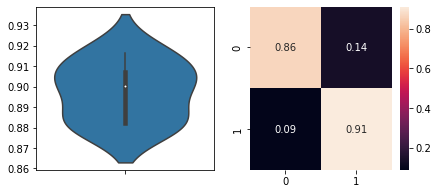

In [107]:
exploring_params = {'alpha': [1e-4, 1e-3, 1e-2, 1e-1, 1e0, 1e1, 1e2, 1e3]
                   }

model = SGDClassifier()
grid_search = GridSearchCV(model, exploring_params, cv=n_cross_val, scoring=scoring)
grid_search.fit(BOW_train, y_train)
y_pred = grid_search.predict(BOW_test)
best_sgd = grid_search.best_estimator_

print("Best estimator: {}".format(best_sgd), end="\n\n")
print("ROC AUC: %.2f" % roc_auc_score(y_test, y_pred), end="\n\n")
print("Classification report:", end="\n\n")
print(classification_report(y_test, y_pred, target_names=['negative','positive']), end="\n\n")

means = grid_search.cv_results_['mean_test_score']
stds = grid_search.cv_results_['std_test_score']
cm_test = confusion_matrix(y_test, y_pred, normalize='true')

f, ax = plt.subplots(1, 2, figsize=(7, 3))
sns.violinplot(y=means, ax=ax[0])
sns.heatmap(cm_test, annot=True, ax=ax[1]);

### Multinominal Naive Bayes

Best estimator: MultinomialNB(alpha=1)

ROC AUC: 0.85

Classification report:

              precision    recall  f1-score   support

    negative       0.84      0.86      0.85       200
    positive       0.86      0.84      0.85       200

    accuracy                           0.85       400
   macro avg       0.85      0.85      0.85       400
weighted avg       0.85      0.85      0.85       400




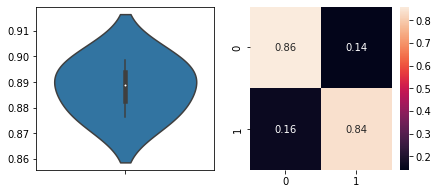

In [108]:
exploring_params = {'alpha': [1, 1e-1, 1e-2]
                   }

model = MultinomialNB()
grid_search = GridSearchCV(model, exploring_params, cv=n_cross_val, scoring=scoring)
grid_search.fit(BOW_train, y_train)
y_pred = grid_search.predict(BOW_test)
best_mnb = grid_search.best_estimator_

print("Best estimator: {}".format(best_mnb), end="\n\n")
print("ROC AUC: %.2f" % roc_auc_score(y_test, y_pred), end="\n\n")
print("Classification report:", end="\n\n")
print(classification_report(y_test, y_pred, target_names=['negative','positive']), end="\n\n")

means = grid_search.cv_results_['mean_test_score']
stds = grid_search.cv_results_['std_test_score']
cm_test = confusion_matrix(y_test, y_pred, normalize='true')

f, ax = plt.subplots(1, 2, figsize=(7, 3))
sns.violinplot(y=means, ax=ax[0])
sns.heatmap(cm_test, annot=True, ax=ax[1]);

### Support Vector Machines (SVM)

Basándonos en el [paper](https://www.csie.ntu.edu.tw/~cjlin/papers/guide/guide.pdf), vamos a utilizar un kernel lineal. Al tener menos instancias que features este es el procedimiento recomendado. 

Best estimator: LinearSVC(C=0.001)

ROC AUC: 0.87

Classification report:

              precision    recall  f1-score   support

    negative       0.87      0.87      0.87       200
    positive       0.87      0.87      0.87       200

    accuracy                           0.87       400
   macro avg       0.87      0.87      0.87       400
weighted avg       0.87      0.87      0.87       400




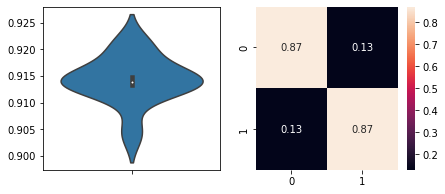

In [109]:
exploring_params = {'C':[0.001, 0.01, 0.1, 1, 10], 
                    'loss': ['hinge', 'squared_hinge']
                   }

model = LinearSVC()
grid_search = GridSearchCV(model, exploring_params, cv=n_cross_val, scoring=scoring)
grid_search.fit(BOW_train, y_train)
y_pred = grid_search.predict(BOW_test)
best_svm = grid_search.best_estimator_

print("Best estimator: {}".format(best_svm), end="\n\n")
print("ROC AUC: %.2f" % roc_auc_score(y_test, y_pred), end="\n\n")
print("Classification report:", end="\n\n")
print(classification_report(y_test, y_pred, target_names=['negative','positive']), end="\n\n")

means = grid_search.cv_results_['mean_test_score']
stds = grid_search.cv_results_['std_test_score']
cm_test = confusion_matrix(y_test, y_pred, normalize='true')

f, ax = plt.subplots(1, 2, figsize=(7, 3))
sns.violinplot(y=means, ax=ax[0])
sns.heatmap(cm_test, annot=True, ax=ax[1]);

### Multilayer Perceptron

Best estimator: MLPClassifier(hidden_layer_sizes=(10,))

ROC AUC: 0.89

Classification report:

              precision    recall  f1-score   support

    negative       0.91      0.86      0.89       200
    positive       0.87      0.92      0.89       200

    accuracy                           0.89       400
   macro avg       0.89      0.89      0.89       400
weighted avg       0.89      0.89      0.89       400




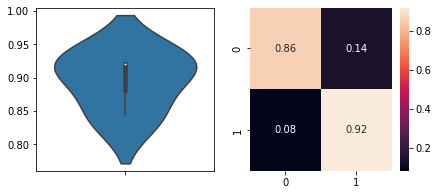

In [110]:
exploring_params = {'hidden_layer_sizes': [(10,),(5,5), (2,2)]}

model = MLPClassifier()
grid_search = GridSearchCV(model, exploring_params, cv=n_cross_val, scoring=scoring)
grid_search.fit(BOW_train, y_train)
y_pred = grid_search.predict(BOW_test)
best_mlp = grid_search.best_estimator_

print("Best estimator: {}".format(best_mlp), end="\n\n")
print("ROC AUC: %.2f" % roc_auc_score(y_test, y_pred), end="\n\n")
print("Classification report:", end="\n\n")
print(classification_report(y_test, y_pred, target_names=['negative','positive']), end="\n\n")

means = grid_search.cv_results_['mean_test_score']
stds = grid_search.cv_results_['std_test_score']
cm_test = confusion_matrix(y_test, y_pred, normalize='true')

f, ax = plt.subplots(1, 2, figsize=(7, 3))
sns.violinplot(y=means, ax=ax[0])
sns.heatmap(cm_test, annot=True, ax=ax[1]);

### Neural Network

In [139]:
alpha = 0.1
nodes_per_hidden_layer = 8
hidden_layer_depth = 1
learning_rate = 1e-02
input_dim = BOW_train.shape[1]
n_cross_val =  2 

In [143]:
# Function to create model, required for KerasClassifier
def create_model():
	# create model
	model = Sequential()
	model.add(Dense(nodes_per_hidden_layer, input_dim=input_dim, activation='relu'))
	model.add(Dense(1, activation='sigmoid'))
	# Compile model
	model.compile(loss='binary_crossentropy', optimizer='adam', metrics=['accuracy'])
	return model

In [144]:
# create model
model = KerasClassifier(build_fn=create_model, verbose=0)
# define the grid search parameters
batch_size = [10, 20, 40, 60, 80, 100]
epochs = [10, 50, 100]
exploring_params = dict(batch_size=batch_size, epochs=epochs)
grid = GridSearchCV(estimator=model, param_grid=exploring_params, n_jobs=-1, cv=n_cross_val)

In [145]:
create_model().summary()

Model: "sequential_7"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense_11 (Dense)            (None, 8)                 106880    
                                                                 
 dense_12 (Dense)            (None, 1)                 9         
                                                                 
Total params: 106,889
Trainable params: 106,889
Non-trainable params: 0
_________________________________________________________________


In [146]:
grid_search.fit(BOW_train, y_train)
y_pred = grid_search.predict(BOW_test)
best_mlp = grid_search.best_estimator_

print("Best estimator: {}".format(best_nn), end="\n\n")
print("ROC AUC: %.2f" % roc_auc_score(y_test, y_pred), end="\n\n")
print("Classification report:", end="\n\n")
print(classification_report(y_test, y_pred, target_names=['negative','positive']), end="\n\n")

means = grid_search.cv_results_['mean_test_score']
stds = grid_search.cv_results_['std_test_score']
cm_test = confusion_matrix(y_test, y_pred, normalize='true')

f, ax = plt.subplots(1, 2, figsize=(7, 3))
sns.violinplot(y=means, ax=ax[0])
sns.heatmap(cm_test, annot=True, ax=ax[1]);

INFO:tensorflow:Assets written to: ram://570f2bdd-6c63-418e-8673-0ce877119326/assets
INFO:tensorflow:Assets written to: ram://21ea82b0-383f-4469-bc16-9a957e05bb4c/assets
INFO:tensorflow:Assets written to: ram://4ae8ba63-9502-417d-8652-93018667468b/assets
INFO:tensorflow:Assets written to: ram://20a727af-dd76-4b84-9866-adb20cec167f/assets
INFO:tensorflow:Assets written to: ram://499d7ba0-78a1-4808-8d01-0957bcf40d9a/assets
INFO:tensorflow:Assets written to: ram://2e4b5c0c-666e-4147-b8da-c7706db4e669/assets
INFO:tensorflow:Assets written to: ram://f9e9aefa-93c8-43bc-8796-1c572bd444e4/assets
INFO:tensorflow:Assets written to: ram://20d5be25-8de0-4f9d-8498-bcc5f2cc1fce/assets
INFO:tensorflow:Assets written to: ram://cdaa1697-2016-4c2b-9ad8-18c97460052a/assets
INFO:tensorflow:Assets written to: ram://f1e3a702-0c4c-4db5-a587-864e949d95ee/assets
INFO:tensorflow:Assets written to: ram://6497bc1f-0d48-47a4-b0d2-ad72b6c49cf2/assets
INFO:tensorflow:Assets written to: ram://9915614f-7211-41e8-8b08-

ValueError: The first argument to `Layer.call` must always be passed.

### Random Forest

Best estimator: RandomForestClassifier(max_depth=20)

ROC AUC: 0.83

Classification report:

              precision    recall  f1-score   support

    negative       0.83      0.82      0.82       200
    positive       0.82      0.83      0.83       200

    accuracy                           0.82       400
   macro avg       0.83      0.82      0.82       400
weighted avg       0.83      0.82      0.82       400




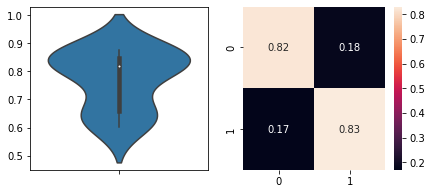

In [147]:
exploring_params = {'n_estimators': [5, 50, 100], 
                    'max_depth': [2, 10, 20, None]
                   }

model = RandomForestClassifier()
grid_search = GridSearchCV(model, exploring_params, cv=n_cross_val, scoring=scoring)
grid_search.fit(BOW_train, y_train)
y_pred = grid_search.predict(BOW_test)
best_rf = grid_search.best_estimator_

print("Best estimator: {}".format(best_rf), end="\n\n")
print("ROC AUC: %.2f" % roc_auc_score(y_test, y_pred), end="\n\n")
print("Classification report:", end="\n\n")
print(classification_report(y_test, y_pred, target_names=['negative','positive']), end="\n\n")

means = grid_search.cv_results_['mean_test_score']
stds = grid_search.cv_results_['std_test_score']
cm_test = confusion_matrix(y_test, y_pred, normalize='true')

f, ax = plt.subplots(1, 2, figsize=(7, 3))
sns.violinplot(y=means, ax=ax[0])
sns.heatmap(cm_test, annot=True, ax=ax[1]);

### AdaBoost

Best estimator: AdaBoostClassifier(n_estimators=500)

ROC AUC: 0.81

Classification report:

              precision    recall  f1-score   support

    negative       0.81      0.81      0.81       200
    positive       0.81      0.81      0.81       200

    accuracy                           0.81       400
   macro avg       0.81      0.81      0.81       400
weighted avg       0.81      0.81      0.81       400




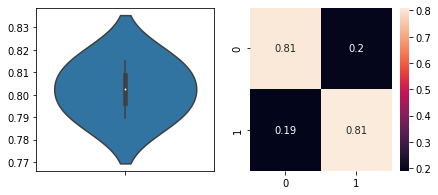

In [148]:
exploring_params = {'n_estimators': [50, 100, 500]}

model = AdaBoostClassifier()
grid_search = GridSearchCV(model, exploring_params, cv=n_cross_val, scoring=scoring)
grid_search.fit(BOW_train, y_train)
y_pred = grid_search.predict(BOW_test)
best_ada = grid_search.best_estimator_

print("Best estimator: {}".format(best_ada), end="\n\n")
print("ROC AUC: %.2f" % roc_auc_score(y_test, y_pred), end="\n\n")
print("Classification report:", end="\n\n")
print(classification_report(y_test, y_pred, target_names=['negative','positive']), end="\n\n")

means = grid_search.cv_results_['mean_test_score']
stds = grid_search.cv_results_['std_test_score']
cm_test = confusion_matrix(y_test, y_pred, normalize='true')

f, ax = plt.subplots(1, 2, figsize=(7, 3))
sns.violinplot(y=means, ax=ax[0])
sns.heatmap(cm_test, annot=True, ax=ax[1]);

### XGBoost

https://www.analyticsvidhya.com/blog/2016/03/complete-guide-parameter-tuning-xgboost-with-codes-python/

In [149]:
model = XGBClassifier(
 learning_rate =0.1,
 n_estimators=1000,
 max_depth=5,
 min_child_weight=1,
 gamma=0,
 subsample=0.8,
 colsample_bytree=0.8,
 objective= 'binary:logistic',
 nthread=4,
 scale_pos_weight=1,
 seed=27)

model.fit(BOW_train, y_train)
y_pred = model.predict(BOW_test)

print("ROC AUC: %.2f" % roc_auc_score(y_test, y_pred), end="\n\n")
print("Classification report:", end="\n\n")
print(classification_report(y_test, y_pred, target_names=['negative','positive']), end="\n\n")

cm_test = confusion_matrix(y_test, y_pred, normalize='true')
sns.violinplot(y=means, ax=ax[0])
sns.heatmap(cm_test, annot=True, ax=ax[1]);

[21:24:24] WARNING: ../src/learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
ROC AUC: 0.84

Classification report:

              precision    recall  f1-score   support

    negative       0.86      0.81      0.84       200
    positive       0.82      0.86      0.84       200

    accuracy                           0.84       400
   macro avg       0.84      0.84      0.84       400
weighted avg       0.84      0.84      0.84       400




[22:21:51] WARNING: ../src/learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
Best estimator: XGBClassifier(base_score=0.5, booster='gbtree', colsample_bylevel=1,
              colsample_bynode=1, colsample_bytree=0.8,
              enable_categorical=False, gamma=0, gpu_id=-1,
              importance_type=None, interaction_constraints='',
              learning_rate=0.1, max_delta_step=0, max_depth=6,
              min_child_weight=4, missing=nan, monotone_constraints='()',
              n_estimators=140, n_jobs=4, nthread=4, num_parallel_tree=1,
              predictor='auto', random_state=27, reg_alpha=0, reg_lambda=1,
              scale_pos_weight=1, seed=27, subsample=0.8, tree_method='exact',
              validate_parameters=1, verbosity=None)

ROC AUC: 0.85

Classification report:

              precision

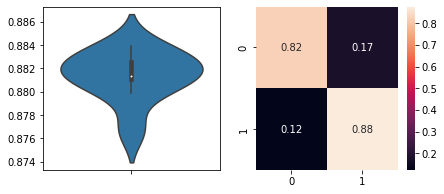

/home/julieta/.local/lib/python3.8/site-packages/xgboost/sklearn.py:1224: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)
/home/julieta/.local/lib/python3.8/site-packages/xgboost/sklearn.py:1224: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)
/home/julieta/.local/lib/python3.8/site-packages/xgboost/sklearn.py:1224: UserWa

[22:21:34] WARNING: ../src/learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[22:21:36] WARNING: ../src/learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[22:21:37] WARNING: ../src/learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[22:21:38] WARNING: ../src/learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old be

/home/julieta/.local/lib/python3.8/site-packages/xgboost/sklearn.py:1224: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)
/home/julieta/.local/lib/python3.8/site-packages/xgboost/sklearn.py:1224: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)
/home/julieta/.local/lib/python3.8/site-packages/xgboost/sklearn.py:1224: UserWa

[22:21:34] WARNING: ../src/learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[22:21:36] WARNING: ../src/learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[22:21:37] WARNING: ../src/learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[22:21:38] WARNING: ../src/learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old be

/home/julieta/.local/lib/python3.8/site-packages/xgboost/sklearn.py:1224: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)
/home/julieta/.local/lib/python3.8/site-packages/xgboost/sklearn.py:1224: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)
/home/julieta/.local/lib/python3.8/site-packages/xgboost/sklearn.py:1224: UserWa

In [155]:
exploring_params = {
 'max_depth':[4,5,6],
 'min_child_weight':[4,5,6]
}

model = XGBClassifier(learning_rate=0.1,
                      n_estimators=140,
                      max_depth=5,
                      min_child_weight=2,
                      gamma=0,
                      subsample=0.8,
                      colsample_bytree=0.8,
                      objective= 'binary:logistic',
                      nthread=4, 
                      scale_pos_weight=1,
                      seed=27)

grid_search = GridSearchCV(model, exploring_params, cv=5, scoring=scoring, n_jobs=4)
grid_search.fit(BOW_train, y_train)
y_pred = grid_search.predict(BOW_test)
best_xgb = grid_search.best_estimator_

print("Best estimator: {}".format(best_xgb), end="\n\n")
print("ROC AUC: %.2f" % roc_auc_score(y_test, y_pred), end="\n\n")
print("Classification report:", end="\n\n")
print(classification_report(y_test, y_pred, target_names=['negative','positive']), end="\n\n")

means = grid_search.cv_results_['mean_test_score']
stds = grid_search.cv_results_['std_test_score']
cm_test = confusion_matrix(y_test, y_pred, normalize='true')

f, ax = plt.subplots(1, 2, figsize=(7, 3))
sns.violinplot(y=means, ax=ax[0])
sns.heatmap(cm_test, annot=True, ax=ax[1]);

### Voting

ROC AUC: 0.84

Classification report:

              precision    recall  f1-score   support

    negative       0.86      0.81      0.84       200
    positive       0.82      0.86      0.84       200

    accuracy                           0.84       400
   macro avg       0.84      0.84      0.84       400
weighted avg       0.84      0.84      0.84       400




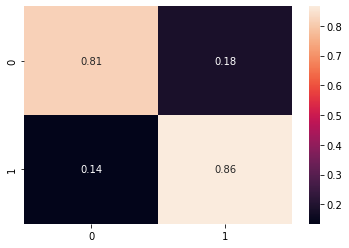

In [150]:
voting_clf = VotingClassifier(estimators=[('lr', best_lr),
                                          ('svm', best_svm),
                                          ('mlp', best_mlp),
                                          ('sgd', best_sgd)
                                         ], 
                              voting='hard')

voting_clf.fit(BOW_train, y_train)
y_pred_vot = voting_clf.predict(BOW_test)
print("ROC AUC: %.2f" % roc_auc_score(y_test, y_pred), end="\n\n")
print("Classification report:", end="\n\n")
print(classification_report(y_test, y_pred, target_names=['negative','positive']), end="\n\n")
cm_test = confusion_matrix(y_test, y_pred, normalize='true')
sns.heatmap(cm_test, annot=True);

In [116]:
# Save the model
joblib.dump(voting_clf, 'sentiment.pkl') 

['sentiment.pkl']

## Trying the classifier on fake movie reviews

In [175]:
reviews_new = ['This movie was excellent', 
               'Absolute joy ride', 
               'Brad Pitt was terrible',
               'Brad Pitt shone through.', 
               'This was certainly a movie',
               'Two thumbs up', 
               'I fell asleep halfway through', 
               "We can't wait for the sequel!!",
               'I cannot recommend this highly enough', 
               'instant classic.', 
               'Brad Pitt was amazing. His performance was Oscar-worthy.']

# Turn text into count vector
reviews_new_counts = vectorizer.transform(reviews_new)
# Turn into tfidf vector
reviews_new_tfidf = vectorizer.transform(reviews_new)

In [176]:
# Have classifier make a prediction
pred = voting_clf.predict(reviews_new_tfidf)

In [177]:
# Print out results
for review, category in zip(reviews_new, pred):
    print('%r => %s \n' % (review, movie_reviews.target_names[category]))

'This movie was excellent' => pos 

'Absolute joy ride' => neg 

'Brad Pitt was terrible' => neg 

'Brad Pitt shone through.' => neg 

'This was certainly a movie' => neg 

'Two thumbs up' => neg 

'I fell asleep halfway through' => neg 

"We can't wait for the sequel!!" => neg 

'I cannot recommend this highly enough' => neg 

'instant classic.' => neg 

'Brad Pitt was amazing. His performance was Oscar-worthy.' => pos 



## Conclusion

In this project, we built and compared multiple models for sentiment analysis on movie reviews, including Logistic Regression, KNN, SGD, Naive Bayes,
SVM, MLP, Random Forest, AdaBoost, XGBoost, and an ensemble Voting Classifier.

The models achieve good accuracy and ROC AUC scores, demonstrating the power of combining NLP techniques like TF-IDF, n-grams, and Word2Vec with machine learning classifiers.

Future improvements could include training deep learning models like BERT, adding more advanced hyperparameter tuning, and deploying the model as a web app or API for real-world use.

<h1><center>End</center></h1>

---